## Readme 

Made by: Johan Knarreborg - johan.knarreborg@gmail.com

This notebook takes your Strava bulk download and plots all of your activites. To download all your Strava data in one folder, look at this link: https://support.strava.com/hc/en-us/articles/216918437-Exporting-your-Data-and-Bulk-Export 

#### Content: 

##### Activity Matrix  &    Area plot 

#### How to use: 

1. Download Strava bulk data 
2. Change DIR_STRAVA to the path of your Strava bulk download
3. Maybe install some of the needed packages 
4. Run cells

For Activity plot: 

4. Play around with matrix dimension (width /height var) 

For Area plot 

4. Change plot center coordinates 
5. Change area radius 





In [3]:
from gpx_converter import Converter 
import os as os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math as math
from fit2gpx import StravaConverter
from colorama import Fore, Style
#If the above section does not work then run some of these to install the packages
#!pip install colorama
#!pip install gpx_converter 
#!pip install fit2gpx

In [19]:
class Strava_plotting:

    def __init__(self, DIR_STRAVA):
        self.DIR_STRAVA = DIR_STRAVA
        
    def convert_all_to_GPX(self): 
        DIR_STRAVA = self.DIR_STRAVA
        #converting all files to GPX files
        strava_conv = StravaConverter(
            dir_in=DIR_STRAVA
        )
        #Unzip the zipped files
        strava_conv.unzip_activities()

        #Add metadata to existing GPX files
        strava_conv.add_metadata_to_gpx()

        #Convert FIT to GPX
        strava_conv.strava_fit_to_gpx() 

    def convert_all_to_CSV(self):
        DIR_STRAVA = self.DIR_STRAVA
        #no need to change anything here
        #converting gpx to csv if activies does not exists 
        if not os.path.exists(DIR_STRAVA+"/activities_csv"):
                os.mkdir(DIR_STRAVA+"/activities_csv")
        for file in sorted(os.listdir(DIR_STRAVA+"/activities_gpx/")):
                f = open(DIR_STRAVA+"/activities_gpx/"+file,'r') 
                f = f.read() 
                where = f.index("<type>")+6
                type = f[where:where+3].lower()
                try:
                        where = f.index("<time>")+6
                except: 
                        #some activites such as pool swimming do not have time stamps and cooridnates
                        continue
                time = f[where:where+10].lower()
                f_in =DIR_STRAVA+"/activities_gpx/"+file
                f_out =DIR_STRAVA+"/activities_csv/"+time+file[0:-4]+type+".csv"
                Converter(input_file=f_in).gpx_to_csv(output_file=f_out)
    

    def remove_small_activites(self): 
        DIR_STRAVA = self.DIR_STRAVA
        #removing small activites. 
        for file in os.listdir(DIR_STRAVA+"/activities_csv"):
            if file == ".DS_Store":
                continue
            else: 
                df =pd.read_csv(DIR_STRAVA+"/activities_csv/"+file)
                if df.size < 100: 
                    os.remove(DIR_STRAVA+"/activities_csv/"+str(file))

    def plot_matrix(self,width ='',height ='',title='Tracking my life',save = False): 
        DIR_STRAVA = self.DIR_STRAVA
        fig = plt.figure(0)
        dir = DIR_STRAVA+"/activities_csv/"
        size  = np.size(os.listdir(DIR_STRAVA+"/activities_csv/"))
        size = int(math.sqrt(size))+1

        # width * height should equal or be greater than the amount of files. You can fiddle around with these 
        if width == '' or height == '':
            width = size -1 
            height = size +1
        else:
            width = width
            height = height
        fig.set_size_inches(width,height)
        c = 0
        r = 0
        color0 = (237/255,109/255,104/255)
        color1 = (206/255,96/255,132/255)
        color2 = (159/255,93/255,146/255)
        color3 = (108/255,91/255,141/255)
        color4 = (66/255,84/255,119/255)
        for file in sorted(os.listdir(dir)): 
            if file == ".DS_Store": 
                continue

            if c == width: 
                c = 0 
                r += 1

            ax = plt.subplot2grid((height,width), (r,c))
            df = pd.read_csv(dir+file)

            #plotting lat lon is weird. Here we account for the distortion of longitude away from the equator.
            df['longitude']=df['longitude']-df['longitude'].mean()
            df['longitude']=df.apply(lambda x: math.cos(math.radians(x['latitude']))*x['longitude'],axis = 1)


            if file[-7:-4] == 'rid' or  file[-7:-4] == "bik": 
                color = color4

                #change kite surf session recorded as bike ride
                if abs(df["latitude"].max()-df["latitude"].min()) < 5/110: 
                    color = color3
            elif file[-7:-4] == "run" or file[-7:-4] == "tra": 
                color = color0
            elif file[-7:-4] == "hik": 
                color = color2
            elif file[-7:-4] == "win" or file[-7:-4] == "sur" or file[-7:-4] == "kit" or file[-7:-4] == "wor": 
                color = color3
            else:
                color = color3
            sns.lineplot(x = "longitude", y ="latitude", data = df,sort = False, estimator=None,ax = ax,color = color,linewidth = 0.7) 
            c +=1 
            plt.axis('off')
            plt.axis('scaled')

        font = {'fontname':'serif'}
        plt.suptitle(title,fontsize = 50,x = 0.5 ,y =0.94,color =color0 ,**font)
        if save == True:
            plt.savefig(DIR_STRAVA+"/pig_matrix.svg",format = "svg",bbox_inches = 'tight')
            plt.savefig(DIR_STRAVA+"/pig_matrix.png",format = "png",dpi = 500,bbox_inches = 'tight')
        plt.show()
    
    def plot_area(self,plot_center =[55.66597639, 12.54277727] ,plot_width_km = 14,save = False): 
        DIR_STRAVA = self.DIR_STRAVA
        #no change needed
        xmax = plot_center[1]+plot_width_km*math.cos(plot_center[0])/111.320 
        xmin = plot_center[1]-plot_width_km*math.cos(plot_center[0])/111.320
        ymax = plot_center[0]+plot_width_km/110.574
        ymin = plot_center[0]-plot_width_km/110.574

        fig = plt.figure(0)
        dir = DIR_STRAVA+"/activities_csv/"
        size  = np.size(os.listdir(DIR_STRAVA+"/activities_csv/"))
        size = int(math.sqrt(size))+1

        # width * height should equal or be greater than the amount of files. You can fiddle around with these 
        width = 20
        height = 20
        fig.set_size_inches(width,height)
        color = (237/255,109/255,104/255)
        color_title = (237/255,109/255,104/255)
        for file in sorted(os.listdir(dir)): 
            if file == ".DS_Store": 
                continue
            df = pd.read_csv(dir+file)

            if ((df.latitude[0] < ymin-ymin) or (df.latitude[0] > ymax+ymax) or (df.longitude[0]> xmax+xmax) or (df.longitude[0]< xmin-xmin)): 
                #print(df.latitude[0],df.longitude[0])
                continue
                
            #plotting lat lon is weird. Here we account for the distortion of longitude away from the equator.
            df['longitude'] = df['longitude']-plot_center[1]
            df['longitude']=df.apply(lambda x: math.cos(math.radians(x['latitude']))*x['longitude'],axis=1)

            sns.lineplot(x = "longitude", y ="latitude", data = df,sort = False, estimator=None,color = color,alpha = 0.6,linewidth = 0.25) 
            plt.axis('off')
            plt.axis('scaled')

        font = {'fontname':'serif'}
        plt.title('Copenhagen',fontsize = 50,x = 0.5 ,y =0.94,color =color,**font)
        plt.xlim([-plot_width_km*math.cos(plot_center[0])/111.320 ,plot_width_km*math.cos(plot_center[0])/111.320 ])
        plt.ylim([ymin,ymax])
        if save == True:
            plt.savefig(DIR_STRAVA+"/pig_area.svg",format = "svg",bbox_inches='tight')
            plt.savefig(DIR_STRAVA+"/pig_area.png",format = "png",dpi = 500,bbox_inches='tight')
        plt.show()
                    
    


In [ ]:
#this the the path to your Strava folder. 
DIR_STRAVA = './export_55748103_20231017'

In [7]:
strava = Strava_plotting(DIR_STRAVA)
strava.convert_all_to_GPX()
strava.convert_all_to_CSV()
strava.remove_small_activites()

## 1 Activity matrix

Here you can change width and height to change matrix dimensions, the title and whether or not to save the figure. 

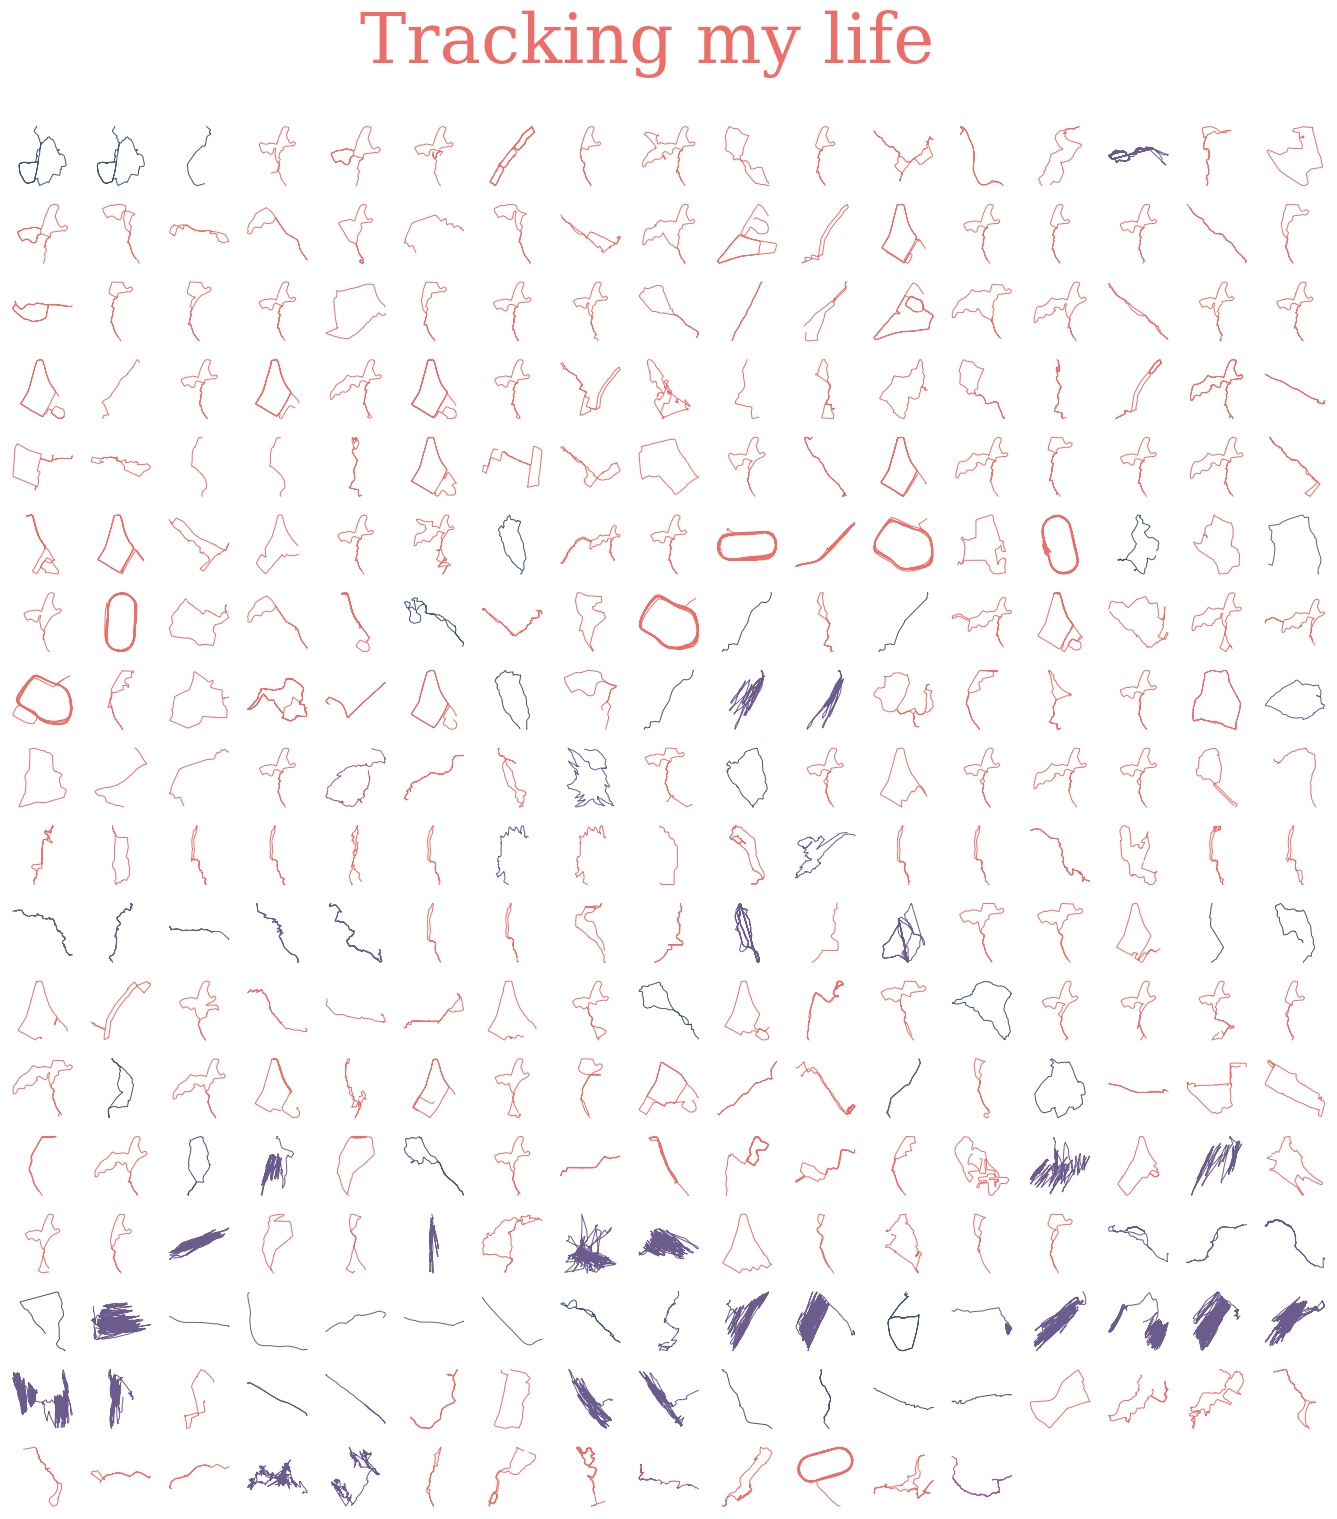

In [21]:
strava.plot_matrix(save=True)

## 2 Area plotting

Here you should change plot_center to the coordinates of the center of your location of choice. 

plot_width_km sets the radius of your plot in km. 

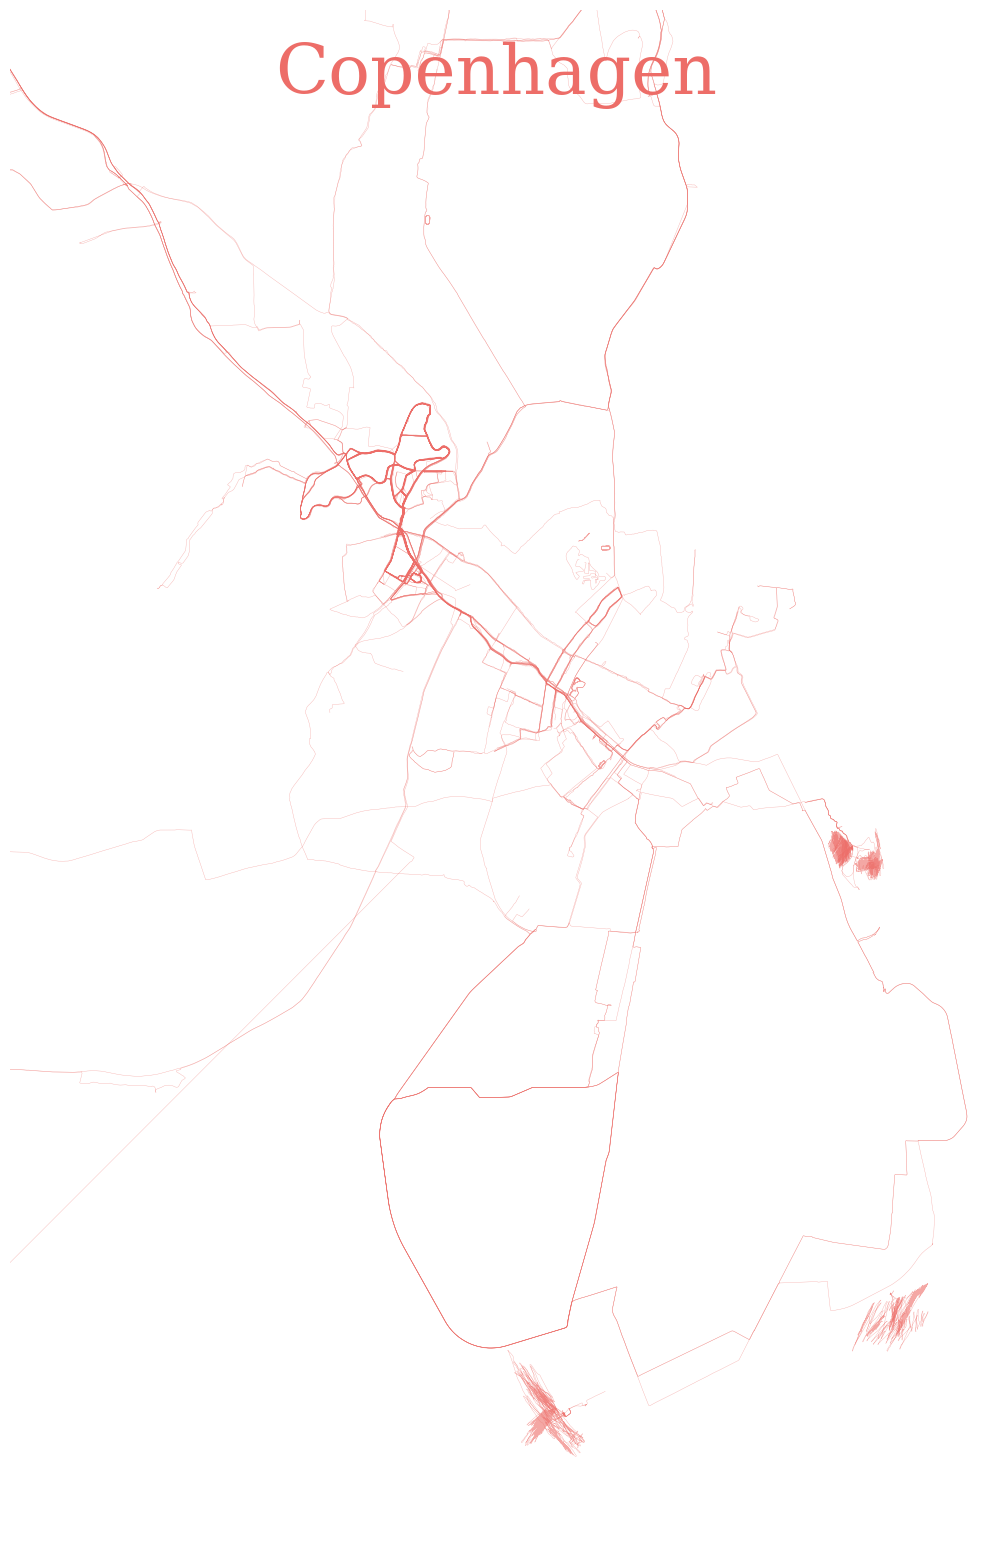

In [22]:
strava.plot_area(save=True)